## Scraping Børsen for articles about Novo Nordisk

In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from afinn import Afinn

import matplotlib.pyplot as plt
import time
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
import datetime
import nltk

In [26]:
# Set up Selenium with Chrome driver
driver = webdriver.Chrome()
driver.maximize_window()

# Specify the URL
url = "https://borsen.dk/"
driver.get(url)
time.sleep(0.5)

# Accept cookies
cookie = driver.find_element(By.ID, 'acceptButton')
cookie.click()
time.sleep(0.5)

# Click on the search button
search_button = driver.find_element(By.CLASS_NAME, 'icon-search')
search_button.click()
time.sleep(2)

# Search for "Novo Nordisk"
search_input = driver.find_element(By.XPATH, '//input[@type="text"]')
search_input.send_keys('Novo Nordisk')
search_input.send_keys(Keys.RETURN)


In [27]:
titles = []
dates = []

while True:
    # Use Beautiful Soup to parse the current page's HTML
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Find all titles and dates with the specified class
    title_divs = soup.find_all('div', class_='title mb-3')
    date_divs = soup.find_all('div', class_='gta-condensed date')

    for title_div, date_div in zip(title_divs, date_divs):
        titles.append(title_div.text.strip())
        dates.append(date_div.text.strip())

    # Try to find the "Next" button/link and click it to go to the next page
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, ".col-3.next a")
        next_button.click()
        time.sleep(2)
    except NoSuchElementException:
        break

# Convert the lists to a pandas DataFrame
df = pd.DataFrame({
    'Title': titles,
    'Date': dates
})

df

,Title,Date
0,Til dragshow hos Nordea: En uge med regnbuefla...,6.38
1,Bocian: Novo skal fejres – men den økonomiske ...,13. AUG.
2,Danskere på rov: Køber virksomheder i udlandet...,12. AUG.
3,"Ugen der gik: Våbenbøvl, millionunderskud og N...",12. AUG.
4,Chefstrateg solgte medicinalaktie alt for hurt...,11. AUG.
...,...,...
26833,Centerkontrakter,28. JUN. 1996
26834,Fremgang for Micro Matic,27. JUN. 1996
26835,Øser af sin miljø-erfaring,26. JUN. 1996
26836,Danske virksomheder tvinges til nedskæringer,24. JUN. 1996


In [28]:
#To filter the articles, we make a list of keywords
#Initially, this list must inclide the names of all Novo Nordisk medical products. These can be obtained as follows: 

# URL to scrape from
url = "https://min.medicin.dk/Adresser/Medicinvirksomheder/126/"

#Defining our logging function
#Disclaimer - this log function is taken directly from the ISDS teaching material
def log(response, logfile, output_path=os.getcwd()):
    if os.path.isfile(logfile):
        log = open(logfile, 'a')
    else:
        log = open(logfile, 'w')
        header = ['timestamp', 'status_code', 'length', 'output_file']
        log.write(';'.join(header) + "\n")

    status_code = response.status_code
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    length = len(response.text)

    with open(logfile, 'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n")
        
# Send a GET request and log response
logfile = 'log_borsen.csv'
response = requests.get(url, headers={'name': 'Lea Lund Jeppesen', 'e-mail':'snk956@alumni.ku.dk', 'purpose':'University of Copenhagen Social Data Science exam project'})
log(response, logfile)

# Parse the content with BeautifulSoup
soup = BeautifulSoup(response.content, 'lxml')

# Find all product elements
product_elements = soup.find_all('a', class_='glob-search_link')

# Extract the product names from the title attribute
product_names = [product['title'] for product in product_elements]

# Removing special characters and numbers from each product name by using Regular Expressions
product_names_cleaned = [re.sub(r'[^a-zA-Z\s]', '', name) for name in product_names]

# For the 28th element, split it into 2 by space
words = product_names_cleaned[28].split()

# Replace the 28th name with the first word
product_names_cleaned[28] = words[0]

# Insert the second word as the 29th element
product_names_cleaned.insert(30, words[1])

#Print the list
product_names_cleaned

['Activelle',
 'Actrapid',
 'Esperoct',
 'Estrofem',
 'Fiasp',
 'GlucaGen',
 'Insulatard',
 'Kliogest',
 'Levemir',
 'Mixtard ',
 'Norditropin',
 'NovoEight',
 'Novofem',
 'NovoMix',
 'NovoNorm',
 'NovoRapid',
 'Novoseven',
 'NovoThirteen',
 'Ozempic',
 'Refixia',
 'Rybelsus',
 'Ryzodeg',
 'Saxenda',
 'Sogroya',
 'Tresiba',
 'Trisekvens',
 'Vagifem',
 'Victoza',
 'Wegovy',
 'Xultophy',
 'Flextouch']

In [29]:
# Define additional keywords, these are determined manually by research on Novo Nordisk medical expertise
keywords = ["Novo", "Nordisk", "insulin", "fedme", "diabetes", "vægttab", "præparat", "overvægt", "slank", "medicin", "pille"]

# We then append the product_names_cleaned list to the keywords list
for product in product_names_cleaned:
    keywords.append(product)

print(keywords)

['Novo', 'Nordisk', 'insulin', 'fedme', 'diabetes', 'vægttab', 'præparat', 'overvægt', 'slank', 'medicin', 'pille', 'Activelle', 'Actrapid', 'Esperoct', 'Estrofem', 'Fiasp', 'GlucaGen', 'Insulatard', 'Kliogest', 'Levemir', 'Mixtard ', 'Norditropin', 'NovoEight', 'Novofem', 'NovoMix', 'NovoNorm', 'NovoRapid', 'Novoseven', 'NovoThirteen', 'Ozempic', 'Refixia', 'Rybelsus', 'Ryzodeg', 'Saxenda', 'Sogroya', 'Tresiba', 'Trisekvens', 'Vagifem', 'Victoza', 'Wegovy', 'Xultophy', 'Flextouch']


In [30]:
# Convert the keywords to lowercase for case-insensitive matching
keywords_lower = [word.lower() for word in keywords]

# Filter the dataframe based on the condition
df_filtered = df[df['Title'].str.lower().str.contains('|'.join(keywords_lower))]

#Reset index
df_filtered = df_filtered.reset_index(drop=True)


dict_en = {'JAN': 'JAN', 'FEB': 'FEB', 'MAR': 'MAR', 'APR': 'APR', 'MAJ': 'MAY', 'JUN': 'JUN', 'JUL': 'JUL', 'AUG': 'AUG', 'SEP': 'SEP', 'OKT': 'OCT', 'NOV': 'NOV', 'DEC': 'DEC'}

def convert_date(date_string):
    # Remove periods
    date_string = date_string.replace('.', '').strip()

    # Translate month names to English
    for danish, english in dict_en.items():
        date_string = date_string.replace(danish, english)

    # Handle different date formats
    if ":" in date_string:  # It's a time
        return datetime.datetime.now().strftime('%Y-%m-%d')  # Return today's date
    elif len(date_string.split()) == 2:  # Day and month
        current_year = datetime.datetime.now().year
        return datetime.datetime.strptime(date_string + f" {current_year}", '%d %b %Y').strftime('%Y-%m-%d')
    else:  # Full date
        return datetime.datetime.strptime(date_string, '%d %b %Y').strftime('%Y-%m-%d')

# Apply the conversion function to the 'Date' column
df_filtered['Date'] = df_filtered['Date'].apply(convert_date)
df_filtered

,Title,Date
0,Bocian: Novo skal fejres – men den økonomiske ...,2023-08-13
1,"Ugen der gik: Våbenbøvl, millionunderskud og N...",2023-08-12
2,Chefstrateg solgte medicinalaktie alt for hurt...,2023-08-11
3,Novo-insidere sælger aktier for 29 mio. kr.,2023-08-11
4,Novos udviklingschef efter vild uge: Flere suc...,2023-08-10
...,...,...
7951,Novo på vej mod rekordresultat,1996-08-15
7952,Novo trak KFX frem til rekord,1996-08-15
7953,Novo-resultat bliver som lovet,1996-08-14
7954,Historien om insulin-krigen i Novo Nordisk,1996-07-18


In [31]:
#Now we want to process the text data

#We define a processing function that carries out the wanted steps 
def process_text(cell_text): 
    cell_text=cell_text.lower() #Change to lower case
    cell_text=re.sub(r'[^\w\s]','',cell_text) #Remove all characters that are not words or numbers
    cell_text=cell_text.split() #Split at whitespace with the split() method (i.e., tokenization)
    return cell_text

#We now apply the process function to the titles 
df_filtered['Title'] = df_filtered['Title'].apply(process_text)
df_filtered

,Title,Date
0,"[bocian, novo, skal, fejres, men, den, økonomi...",2023-08-13
1,"[ugen, der, gik, våbenbøvl, millionunderskud, ...",2023-08-12
2,"[chefstrateg, solgte, medicinalaktie, alt, for...",2023-08-11
3,"[novoinsidere, sælger, aktier, for, 29, mio, kr]",2023-08-11
4,"[novos, udviklingschef, efter, vild, uge, fler...",2023-08-10
...,...,...
7951,"[novo, på, vej, mod, rekordresultat]",1996-08-15
7952,"[novo, trak, kfx, frem, til, rekord]",1996-08-15
7953,"[novoresultat, bliver, som, lovet]",1996-08-14
7954,"[historien, om, insulinkrigen, i, novo, nordisk]",1996-07-18


In [32]:
# Convert the 'Date' column to datetime format
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Filter the dataframe to only include rows from the year 2000 onwards
df_filtered = df_filtered[df_filtered['Date'].dt.year >= 2000]

# Reset the index after filtering
df_filtered = df_filtered.reset_index(drop=True)
df_filtered

,Title,Date
0,"[bocian, novo, skal, fejres, men, den, økonomi...",2023-08-13
1,"[ugen, der, gik, våbenbøvl, millionunderskud, ...",2023-08-12
2,"[chefstrateg, solgte, medicinalaktie, alt, for...",2023-08-11
3,"[novoinsidere, sælger, aktier, for, 29, mio, kr]",2023-08-11
4,"[novos, udviklingschef, efter, vild, uge, fler...",2023-08-10
...,...,...
7614,"[læger, sætter, pensionspenge, i, medicinalakt...",2000-01-27
7615,"[medicinalbranchen, ramt, af, formkrise]",2000-01-20
7616,"[fremstød, for, dansk, medicin, i, ægypten]",2000-01-19
7617,"[fusioner, kan, presse, novos, alliancestrategi]",2000-01-18


In [33]:
#We want to remove stopwords
nltk.download('stopwords')
stop = stopwords.words('danish')

#Remove stopwards
df_filtered['title_nostop'] = df_filtered['Title'].apply(lambda title: [i for i in title if i not in stop])

#We ensure that some stopwords were actually removed
print(len(df_filtered['Title'].iloc[0]), len(df_filtered['title_nostop'].iloc[0]))

#Print the data_frame
df_filtered

10 6


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leajeppesen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Title,Date,title_nostop
0,"[bocian, novo, skal, fejres, men, den, økonomi...",2023-08-13,"[bocian, novo, fejres, økonomiske, fleksibilit..."
1,"[ugen, der, gik, våbenbøvl, millionunderskud, ...",2023-08-12,"[ugen, gik, våbenbøvl, millionunderskud, novoa..."
2,"[chefstrateg, solgte, medicinalaktie, alt, for...",2023-08-11,"[chefstrateg, solgte, medicinalaktie, hurtigt,..."
3,"[novoinsidere, sælger, aktier, for, 29, mio, kr]",2023-08-11,"[novoinsidere, sælger, aktier, 29, mio, kr]"
4,"[novos, udviklingschef, efter, vild, uge, fler...",2023-08-10,"[novos, udviklingschef, vild, uge, flere, succ..."
...,...,...,...
7614,"[læger, sætter, pensionspenge, i, medicinalakt...",2000-01-27,"[læger, sætter, pensionspenge, medicinalaktier]"
7615,"[medicinalbranchen, ramt, af, formkrise]",2000-01-20,"[medicinalbranchen, ramt, formkrise]"
7616,"[fremstød, for, dansk, medicin, i, ægypten]",2000-01-19,"[fremstød, dansk, medicin, ægypten]"
7617,"[fusioner, kan, presse, novos, alliancestrategi]",2000-01-18,"[fusioner, kan, presse, novos, alliancestrategi]"


In [34]:
nltk.download('omw-1.4')
nltk.download('wordnet')

# Initialize the Danish SnowballStemmer
stemmer = SnowballStemmer("danish")

# Define the stemming function
def stem_text(tokens):
    return [stemmer.stem(token) for token in tokens]

# Apply the function to each row of the 'title_nostop' column
df_filtered['title_stemmed'] = df_filtered['title_nostop'].apply(stem_text)

#We check to see of the stemmed words make sense
df_filtered
#From this we conclude that the stemmed danish words are often incorrect. Thus, we continue with determining the sentiment of the nostop column.

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/leajeppesen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leajeppesen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Date,title_nostop,title_stemmed
0,"[bocian, novo, skal, fejres, men, den, økonomi...",2023-08-13,"[bocian, novo, fejres, økonomiske, fleksibilit...","[bocian, novo, fejr, økonomisk, fleksibilit, s..."
1,"[ugen, der, gik, våbenbøvl, millionunderskud, ...",2023-08-12,"[ugen, gik, våbenbøvl, millionunderskud, novoa...","[ugen, gik, våbenbøvl, millionunderskud, novoa..."
2,"[chefstrateg, solgte, medicinalaktie, alt, for...",2023-08-11,"[chefstrateg, solgte, medicinalaktie, hurtigt,...","[chefstrateg, solg, medicinalakti, hurt, reali..."
3,"[novoinsidere, sælger, aktier, for, 29, mio, kr]",2023-08-11,"[novoinsidere, sælger, aktier, 29, mio, kr]","[novoinsid, sælg, akti, 29, mio, kr]"
4,"[novos, udviklingschef, efter, vild, uge, fler...",2023-08-10,"[novos, udviklingschef, vild, uge, flere, succ...","[novo, udviklingschef, vild, uge, fler, succes..."
...,...,...,...,...
7614,"[læger, sætter, pensionspenge, i, medicinalakt...",2000-01-27,"[læger, sætter, pensionspenge, medicinalaktier]","[læg, sæt, pensionspeng, medicinalakti]"
7615,"[medicinalbranchen, ramt, af, formkrise]",2000-01-20,"[medicinalbranchen, ramt, formkrise]","[medicinalbranch, ramt, formkris]"
7616,"[fremstød, for, dansk, medicin, i, ægypten]",2000-01-19,"[fremstød, dansk, medicin, ægypten]","[fremstød, dansk, medicin, ægypt]"
7617,"[fusioner, kan, presse, novos, alliancestrategi]",2000-01-18,"[fusioner, kan, presse, novos, alliancestrategi]","[fusion, kan, pres, novo, alliancestrategi]"


In [35]:
#We determne the sentiment using a predefined lexicon
# Initialize the Afinn object for Danish
afn = Afinn(language='da', emoticons=True)

# Convert the list of words in 'title_stemmed' to a single string and then apply the AFINN sentiment scoring function
df_filtered['sentiment_score'] = df_filtered['title_nostop'].apply(lambda title_list: afn.score(' '.join(title_list)))

#Display the Data Frame
df_filtered

,Title,Date,title_nostop,title_stemmed,sentiment_score
0,"[bocian, novo, skal, fejres, men, den, økonomi...",2023-08-13,"[bocian, novo, fejres, økonomiske, fleksibilit...","[bocian, novo, fejr, økonomisk, fleksibilit, s...",3.0
1,"[ugen, der, gik, våbenbøvl, millionunderskud, ...",2023-08-12,"[ugen, gik, våbenbøvl, millionunderskud, novoa...","[ugen, gik, våbenbøvl, millionunderskud, novoa...",0.0
2,"[chefstrateg, solgte, medicinalaktie, alt, for...",2023-08-11,"[chefstrateg, solgte, medicinalaktie, hurtigt,...","[chefstrateg, solg, medicinalakti, hurt, reali...",-4.0
3,"[novoinsidere, sælger, aktier, for, 29, mio, kr]",2023-08-11,"[novoinsidere, sælger, aktier, 29, mio, kr]","[novoinsid, sælg, akti, 29, mio, kr]",0.0
4,"[novos, udviklingschef, efter, vild, uge, fler...",2023-08-10,"[novos, udviklingschef, vild, uge, flere, succ...","[novo, udviklingschef, vild, uge, fler, succes...",2.0
...,...,...,...,...,...
7614,"[læger, sætter, pensionspenge, i, medicinalakt...",2000-01-27,"[læger, sætter, pensionspenge, medicinalaktier]","[læg, sæt, pensionspeng, medicinalakti]",0.0
7615,"[medicinalbranchen, ramt, af, formkrise]",2000-01-20,"[medicinalbranchen, ramt, formkrise]","[medicinalbranch, ramt, formkris]",-2.0
7616,"[fremstød, for, dansk, medicin, i, ægypten]",2000-01-19,"[fremstød, dansk, medicin, ægypten]","[fremstød, dansk, medicin, ægypt]",0.0
7617,"[fusioner, kan, presse, novos, alliancestrategi]",2000-01-18,"[fusioner, kan, presse, novos, alliancestrategi]","[fusion, kan, pres, novo, alliancestrategi]",0.0


In [36]:
#Print the min and max sentiment score to ensure that scale in sensible
min_sentiment = (df_filtered['sentiment_score'].min())
max_sentiment = (df_filtered['sentiment_score'].max())

print("Minimum Sentiment Score:", min_sentiment)
print("Maximum Sentiment Score:", max_sentiment)

Minimum Sentiment Score: -6.0
Maximum Sentiment Score: 9.0


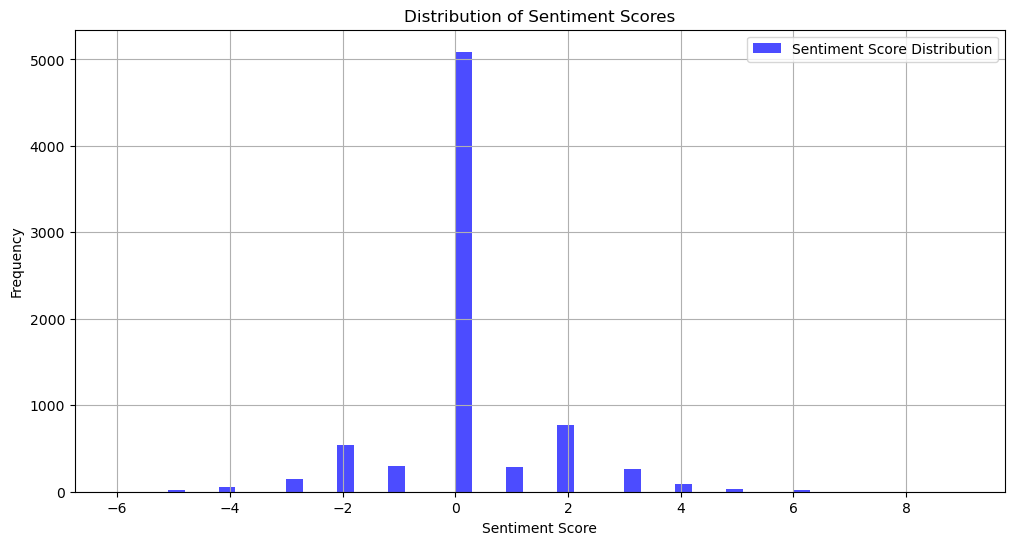

In [37]:
# Plotting the distribution of sentiment scores
plt.figure(figsize=(12, 6))
plt.hist(df_filtered['sentiment_score'], bins=50, color='blue', alpha=0.7, label='Sentiment Score Distribution')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
#Rename the dataframe
daily_stats_borsen=df_filtered

#Now we want to convert the dataframe daily_stats_borsen to a csv file
daily_stats_borsen.to_csv('./CSV/daily_stats_borsen.csv', index=False)